In [15]:
import os
import torch
import torch.nn as nn
from lion_pytorch import Lion
import torchvision.transforms as transforms
import torch.optim as optim
from th import coatnet, CNNModel, trainer, loader, plot, evaluator

ImportError: cannot import name 'evaluator' from 'th' (c:\Users\silba\Desktop\TekSaglik\th\__init__.py)

In [ ]:
img_size = (224, 224)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
#Basic CNN Model Build
model = CNNModel(img_size=img_size).to(device)
optimizer_class = Lion
model_path = os.path.join("pths", f"stroke_detection_model_{model.__class__.__name__}.pth")
criterion = nn.BCELoss()
learning_rate = 1e-4
num_epochs = 10

In [10]:
#Data load
data_dir = "dataset"
train_loader, val_loader = loader(data_dir, transform=transform, split_ratio=0.8, batch_size=batch_size, shuffle=True)

In [11]:
#Train the CNN model
train_losses, train_accuracies, val_losses, val_accuracies = trainer(model, train_loader, val_loader, num_epochs, 
                                                                         criterion, optimizer_class, learning_rate, 
                                                                         model_path=model_path, device=device)

Epoch 1/10, Training Loss: 0.5123, Training Accuracy: 75.02%, Validation Accuracy: 79.99%
Epoch 2/10, Training Loss: 0.3227, Training Accuracy: 86.56%, Validation Accuracy: 87.26%
Epoch 3/10, Training Loss: 0.1823, Training Accuracy: 92.71%, Validation Accuracy: 90.86%
Epoch 4/10, Training Loss: 0.0956, Training Accuracy: 96.40%, Validation Accuracy: 92.94%
Epoch 5/10, Training Loss: 0.0562, Training Accuracy: 97.82%, Validation Accuracy: 92.44%
Epoch 6/10, Training Loss: 0.0439, Training Accuracy: 98.41%, Validation Accuracy: 93.23%
Epoch 7/10, Training Loss: 0.0259, Training Accuracy: 99.24%, Validation Accuracy: 93.74%
Epoch 8/10, Training Loss: 0.0270, Training Accuracy: 99.17%, Validation Accuracy: 93.88%
Epoch 9/10, Training Loss: 0.0238, Training Accuracy: 99.23%, Validation Accuracy: 94.17%
Epoch 10/10, Training Loss: 0.0247, Training Accuracy: 99.08%, Validation Accuracy: 95.10%


In [ ]:
#Evaluate the CNN model
test_dir = "test_dataset"
test_loader_head_ct = loader(os.path.join(test_dir, "head_ct"), transform=transform, batch_size=32, shuffle=False)
test_loader_brain_ct = loader(os.path.join(test_dir, "brain_ct"), transform=transform, batch_size=32, shuffle=False)

accuracy_head_ct = evaluator(model, test_loader_head_ct, device)
accuracy_brain_ct = evaluator(model, test_loader_brain_ct, device)

total_accuracy = (accuracy_head_ct + accuracy_brain_ct) / 2

print(f'Head CT Test Accuracy: {accuracy_head_ct * 100:.2f}%')
print(f'Brain CT Test Accuracy: {accuracy_brain_ct * 100:.2f}%')
print(f'Total Accuracy: {total_accuracy * 100:.2f}%')

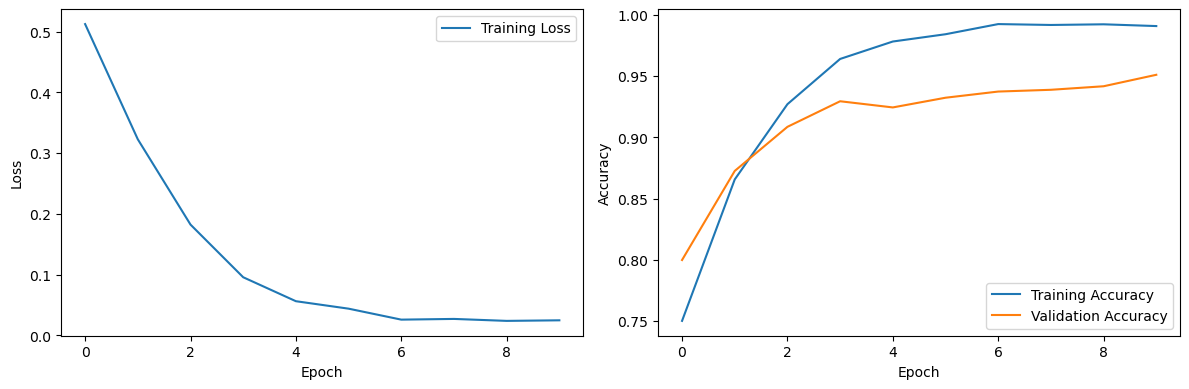

In [12]:
#Plot the CNN model metrics
plot(train_losses, train_accuracies, val_losses, val_accuracies)

In [13]:
#CoAtNet Build
model = coatnet(image_size=img_size, num_classes=1).to(device)
optimizer_class = Lion
num_epochs = 5
model_path = f"stroke_detection_model_{model.__class__.__name__}.pth"
train_loader, val_loader = loader(data_dir, transform=transform, split_ratio=0.8, batch_size=batch_size, shuffle=True)

c:\Users\silba\anaconda3\envs\dreamer\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
#Train the CoAtNet model
train_losses, train_accuracies, val_losses, val_accuracies = trainer(model, train_loader, val_loader, num_epochs, 
                                                                         criterion, optimizer_class, learning_rate, 
                                                                         model_path=model_path, device=device)

KeyboardInterrupt: 

In [ ]:
#Plot the CoAtNet model metrics
plot(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
#Evaluate the CoAtNet model
accuracy_head_ct = evaluator(model, test_loader_head_ct, device)
accuracy_brain_ct = evaluator(model, test_loader_brain_ct, device)

total_accuracy = (accuracy_head_ct + accuracy_brain_ct) / 2

print(f'Head CT Test Accuracy: {accuracy_head_ct * 100:.2f}%')
print(f'Brain CT Test Accuracy: {accuracy_brain_ct * 100:.2f}%')
print(f'Total Accuracy: {total_accuracy * 100:.2f}%')